# STATS M148 Final Notebook

This is our supplementary notebook file that is a repository of all the programming done for:

- exploratory analysis
- data cleaning and manipulation
- data visualization
- data modeling and analysis

All programming in this file was done by Group 7: Joshua Susanto, Yash Panjwani, Aaron Tae, and Liaohan Wang

In [2]:
# import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from collections import Counter
from statsmodels.graphics.mosaicplot import mosaic
import ast
import seaborn as sns
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime
from sklearn.decomposition import PCA
import numpy.linalg as la
from sklearn.cluster import KMeans

## Data Cleaning and Manipulation

**Note:** The programming in this section should not be ran, the results of this data cleaning have been exported into another file. The process of manipulating the entire dataset was extremely time consuming and computationally expensive. Our new dataset will be submitted as well for reproduction.

In [ ]:
# read dataset
fingerhut_data = pd.read_csv('export.csv')

In [ ]:
# first view
fingerhut_data

In [ ]:
# dropping the duplicate rows
fingerhut_data = fingerhut_data.drop_duplicates(subset = ['customer_id', 'account_id', 'event_name', 'event_timestamp'])
fingerhut_data = fingerhut_data.reset_index()

In [ ]:
# creating our wide data
new_df = pd.DataFrame()
event_names = list(set(fingerhut_data['event_name']))
event_list = []
for i in range(len(fingerhut_data)-1):
    event_list.append(fingerhut_data['event_name'][i])
        print(i)
    if fingerhut_data['journey_steps_until_end'][i+1] == 1:
        event_dict = dict.fromkeys(event_names, 0)
        for j in range(len(event_list)):
            event_dict[event_list[j]] += 1
        new_df = new_df.append([[fingerhut_data['customer_id'][i], fingerhut_data['account_id'][i], event_list, list(event_dict.values()), "promotion_created" in event_list, "order_shipped" in event_list]])
        event_list = []

In [ ]:
# first look at new wide dataframe
new_df

In [ ]:
# rename columns
new_df = new_df.rename(columns = {0:'customer_id', 
                                  1:'account_id', 
                                  2:'event_list', 
                                  3:'frequency_vector', 
                                  4:'recieved_promo', 
                                  5:'journey_successful'})

In [ ]:
# export new dataframe
new_df.to_csv('transformed_data.csv')

## Exploratory Analysis 

In [7]:
# read new dataset 
data = pd.read_csv('transformed_data.csv')
data.head()

,Unnamed: 0,customer_id,account_id,event_list,frequency_vector,recieved_promo,journey_successful
0,0,-784961211,1773350293,"['application_web_approved', 'application_web_...","[0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, ...",False,False
1,0,15849251,383997507,"['browse_products', 'browse_products', 'browse...","[0, 0, 66, 0, 0, 0, 0, 5, 0, 1, 0, 0, 0, 6, 0,...",True,False
2,0,155529381,1786111954,"['campaign_click', 'application_web_approved',...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",False,False
3,0,-1697747935,-1016455199,"['application_web_view', 'application_web_view...","[0, 0, 0, 0, 0, 0, 0, 11, 0, 1, 0, 0, 0, 0, 0,...",True,False
4,0,-986357645,1289564882,"['application_web_approved', 'browse_products'...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",False,False


In [13]:
event_order = ['catalog_(email)_(experian)',
 'pre-application_(3rd_party_affiliates)',
 'browse_products',
 'application_phone_pending',
 'application_phone_declined',
 'begin_checkout',
 'campaignemail_clicked',
 'application_web_view',
 'place_order_web',
 'application_web_submit',
 'fingerhut_university',
 'place_order_phone',
 'account_downpaymentreceived',
 'view_cart',
 'order_shipped',
 'application_phone_approved',
 'application_web_declined',
 'place_downpayment',
 'application_web_pending',
 'site_registration',
 'catalog_(mail)',
 'campaign_click',
 'add_to_cart',
 'promotion_created',
 'account_downpaymentcleared',
 'account_activitation',
 'customer_requested_catalog_(digital)',
 'application_web_approved']

### Promotion Exploration

In [9]:
promo_account_id = data[data['recieved_promo']]
promo_account_id.size / data.size

0.7535353267663959

Around 75.3% of accounts have every recieved promotion

In [10]:
nopromo_account_id = data[-data['recieved_promo']]
nopromo_account_id.size / data.size

0.24646467323360408

Around 24.7% of accounts have never recieved promotion

In [11]:
promo_sucess = promo_account_id[promo_account_id['journey_successful']]
promo_sucess.size / promo_account_id.size

0.17453884328355357

Around 17.4% of accounts that ever received promotion completed their orders

In [12]:
nopromo_sucess = nopromo_account_id[nopromo_account_id['journey_successful']]
nopromo_sucess.size / nopromo_account_id.size

0.22086932130293008

Around 22% of account that never received promotion completed their orders

In [13]:
crosstable = pd.crosstab(data['recieved_promo'], data['journey_successful'])
crosstable = pd.DataFrame(crosstable)
crosstable

journey_successful,False,True
recieved_promo,,
False,333316,94489
True,1079671,228290


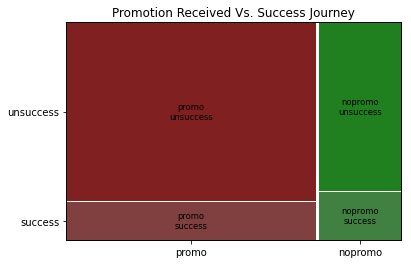

In [14]:
corsstable_data = {('promo', 'success'): 228290, ('promo', 'unsuccess'): 1079671, ('nopromo', 'success'): 94489, ('nopromo', 'unsuccess'): 333316}

mosaic_plot = mosaic(corsstable_data, gap=0.01, title='Promotion Received Vs. Success Journey')

# plt.savefig('Promotion Received Vs. Success Journey Mosaic Plot.png')
plt.show()

### Events Frequencies of All Promoted + Sucessful Accounts

In [15]:
promo_sucess_freq = np.zeros(28) # total 28 events
for i in promo_sucess['frequency_vector'] :
    i = ast.literal_eval(i)
    promo_sucess_freq = promo_sucess_freq + np.array(i, dtype=float)

In [16]:
promo_sucess_freq

array([4.000000e+01, 2.101400e+04, 5.839203e+06, 0.000000e+00,
       6.600000e+01, 9.061120e+05, 3.239770e+05, 8.988490e+05,
       2.118690e+05, 1.983990e+05, 6.500000e+01, 2.627900e+04,
       4.947000e+03, 2.163699e+06, 2.282900e+05, 4.134000e+03,
       6.072000e+03, 2.791520e+05, 4.000000e+00, 2.815000e+03,
       1.397960e+05, 1.353100e+05, 1.270003e+06, 8.494710e+05,
       2.269480e+05, 2.288130e+05, 0.000000e+00, 2.252060e+05])

In [17]:
zip_promo_success = dict(zip(event_order, promo_sucess_freq))
zip_promo_success

{'catalog_(email)_(experian)': 40.0,
 'pre-application_(3rd_party_affiliates)': 21014.0,
 'browse_products': 5839203.0,
 'application_phone_pending': 0.0,
 'application_phone_declined': 66.0,
 'begin_checkout': 906112.0,
 'campaignemail_clicked': 323977.0,
 'application_web_view': 898849.0,
 'place_order_web': 211869.0,
 'application_web_submit': 198399.0,
 'fingerhut_university': 65.0,
 'place_order_phone': 26279.0,
 'account_downpaymentreceived': 4947.0,
 'view_cart': 2163699.0,
 'order_shipped': 228290.0,
 'application_phone_approved': 4134.0,
 'application_web_declined': 6072.0,
 'place_downpayment': 279152.0,
 'application_web_pending': 4.0,
 'site_registration': 2815.0,
 'catalog_(mail)': 139796.0,
 'campaign_click': 135310.0,
 'add_to_cart': 1270003.0,
 'promotion_created': 849471.0,
 'account_downpaymentcleared': 226948.0,
 'account_activitation': 228813.0,
 'customer_requested_catalog_(digital)': 0.0,
 'application_web_approved': 225206.0}

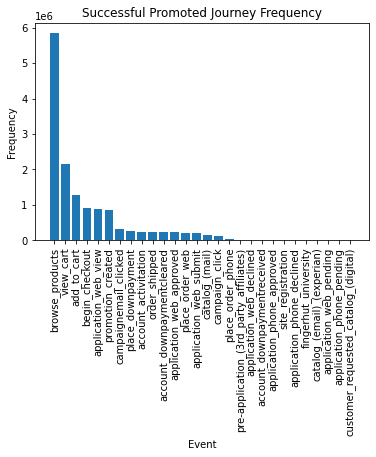

In [18]:
zip_promo_success = dict(zip(event_order, promo_sucess_freq))

events = range(1, len(zip_promo_success) + 1)

sorted_data = sorted(zip(zip_promo_success.keys(), zip_promo_success.values()), key=lambda x: x[1], reverse=True)
sorted_events, sorted_freq = zip(*sorted_data)

plt.bar(events, sorted_freq)
plt.xlabel('Event') 
plt.ylabel('Frequency')
plt.title('Successful Promoted Journey Frequency')
plt.xticks(events, sorted_events, rotation='vertical')  # Adjust rotation as needed

# plt.savefig('Successful Promoted Journey Frequency.png')
plt.show()

### Events Frequencies of ALL Promoted + Unsucessful Accounts

In [19]:
promo_unsucess = promo_account_id[-promo_account_id['journey_successful']]
promo_unsucess_freq = np.zeros(28) # total 28 events
for i in promo_unsucess['frequency_vector'] :
    i = ast.literal_eval(i)
    promo_unsucess_freq = promo_unsucess_freq + np.array(i, dtype=float)

In [20]:
promo_unsucess_freq

array([4.1900000e+02, 9.9825000e+04, 1.3009333e+07, 0.0000000e+00,
       2.3900000e+02, 1.5668180e+06, 1.1504880e+06, 4.0510320e+06,
       3.7260000e+04, 8.8395900e+05, 8.2000000e+01, 1.6186000e+04,
       1.2250000e+03, 3.8546320e+06, 0.0000000e+00, 1.6464000e+04,
       3.1000000e+04, 2.5509000e+04, 4.8000000e+01, 1.3527000e+04,
       2.0855440e+06, 6.6050100e+05, 2.5281320e+06, 6.0026730e+06,
       1.0528000e+04, 7.6035000e+04, 2.0000000e+00, 1.0653140e+06])

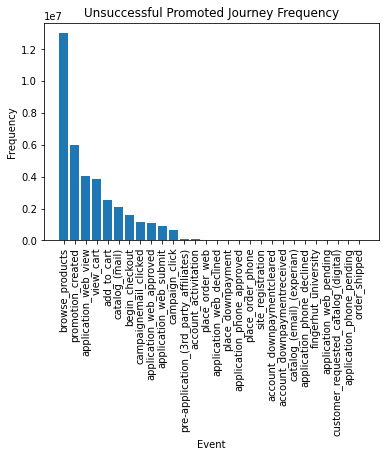

In [21]:
zip_promo_unsuccess = dict(zip(event_order, promo_unsucess_freq))

events = range(1, len(zip_promo_unsuccess) + 1)

sorted_data2 = sorted(zip(zip_promo_unsuccess.keys(), zip_promo_unsuccess.values()), key=lambda x: x[1], reverse=True)
sorted_events2, sorted_freq2 = zip(*sorted_data2)

plt.bar(events, sorted_freq2)
plt.xlabel('Event') 
plt.ylabel('Frequency')
plt.title('Unsuccessful Promoted Journey Frequency')
plt.xticks(events, sorted_events2, rotation='vertical')  # Adjust rotation as needed

# plt.savefig('Unsuccessful Promoted Journey Frequency.png')
plt.show()

In [22]:
zip_promo_unsuccess

{'catalog_(email)_(experian)': 419.0,
 'pre-application_(3rd_party_affiliates)': 99825.0,
 'browse_products': 13009333.0,
 'application_phone_pending': 0.0,
 'application_phone_declined': 239.0,
 'begin_checkout': 1566818.0,
 'campaignemail_clicked': 1150488.0,
 'application_web_view': 4051032.0,
 'place_order_web': 37260.0,
 'application_web_submit': 883959.0,
 'fingerhut_university': 82.0,
 'place_order_phone': 16186.0,
 'account_downpaymentreceived': 1225.0,
 'view_cart': 3854632.0,
 'order_shipped': 0.0,
 'application_phone_approved': 16464.0,
 'application_web_declined': 31000.0,
 'place_downpayment': 25509.0,
 'application_web_pending': 48.0,
 'site_registration': 13527.0,
 'catalog_(mail)': 2085544.0,
 'campaign_click': 660501.0,
 'add_to_cart': 2528132.0,
 'promotion_created': 6002673.0,
 'account_downpaymentcleared': 10528.0,
 'account_activitation': 76035.0,
 'customer_requested_catalog_(digital)': 2.0,
 'application_web_approved': 1065314.0}

### Visualizing a Journey

In [23]:
# a smaller sample of the original data that was provided in class
df = pd.read_csv("even_smaller_sample.csv")

In [24]:
df.head()

,customer_id,account_id,stage,ed_id,event_name,event_timestamp,journey_steps_until_end,journey_id,milestone_number
0,278713037,-1812321640,Discover,2,campaign_click,2021-05-31 06:00:00,1,1.0,NaN
1,278713037,-1812321640,Apply for Credit,19,application_web_view,2021-05-31 23:11:03,2,1.0,NaN
2,278713037,-1812321640,Apply for Credit,3,application_web_submit,2021-05-31 23:11:51,3,1.0,NaN
3,278713037,-1812321640,Apply for Credit,19,application_web_view,2021-05-31 23:11:51,4,1.0,NaN
4,278713037,-1812321640,Apply for Credit,19,application_web_view,2021-05-31 23:11:51,5,1.0,NaN


In [25]:
df = df.drop(columns = ["milestone_number"])

In [26]:
ordered_accounts = df[df["ed_id"] == 28]["customer_id"].unique()
ordered_df = df[df["customer_id"].isin(ordered_accounts)]
nonorder_df = df[~df["customer_id"].isin(ordered_accounts)]

In [27]:
nonorder_df["journey_steps_until_end"].mean(), ordered_df["journey_steps_until_end"].mean()

(39.309815566333434, 49.64738848726015)

In [28]:
## test
test_df = ordered_df.groupby(["account_id", "customer_id"])
a=np.arange(test_df.ngroups)
np.random.shuffle(a)
test_df = ordered_df[test_df.ngroup().isin(a[:5])]
test_df["account_id"].unique()

array([-1742723851,   164736711,  1245360359,  1558655626,  -187189340])

In [29]:
## test
test_df = test_df.reset_index(drop = True)
accounts = test_df["account_id"].unique()
colors = ['b', 'g', 'r', 'm', 'y']
test_df["color"] = np.nan
test_df.head()

,customer_id,account_id,stage,ed_id,event_name,event_timestamp,journey_steps_until_end,journey_id,color
0,1019980524,-1742723851,NaN,1,promotion_created,2021-10-15 01:50:48.75,1,NaN,NaN
1,1019980524,-1742723851,NaN,21,catalog_(mail),2021-10-18,2,NaN,NaN
2,1019980524,-1742723851,Apply for Credit,19,application_web_view,2021-10-27 20:01:26,3,1.0,NaN
3,1019980524,-1742723851,Apply for Credit,19,application_web_view,2021-10-27 20:01:33,4,1.0,NaN
4,1019980524,-1742723851,Apply for Credit,19,application_web_view,2021-10-27 20:02:28,5,1.0,NaN


In [30]:
for i in range(len(test_df)):
    if test_df["account_id"][i] == accounts[0]:
        test_df["color"][i] = colors[0]
    elif test_df["account_id"][i] == accounts[1]:
        test_df["color"][i] = colors[1]
    elif test_df["account_id"][i] == accounts[2]:
        test_df["color"][i] = colors[2]
    elif test_df["account_id"][i] == accounts[3]:
        test_df["color"][i] = colors[3]
    elif test_df["account_id"][i] == accounts[4]:
        test_df["color"][i] = colors[4]
    else: 
        np.nan

/var/folders/z4/1nckxbbs45q8z44xg1hvdp8c0000gn/T/ipykernel_1712/875882570.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["color"][i] = colors[0]
/Users/joshuasusanto/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


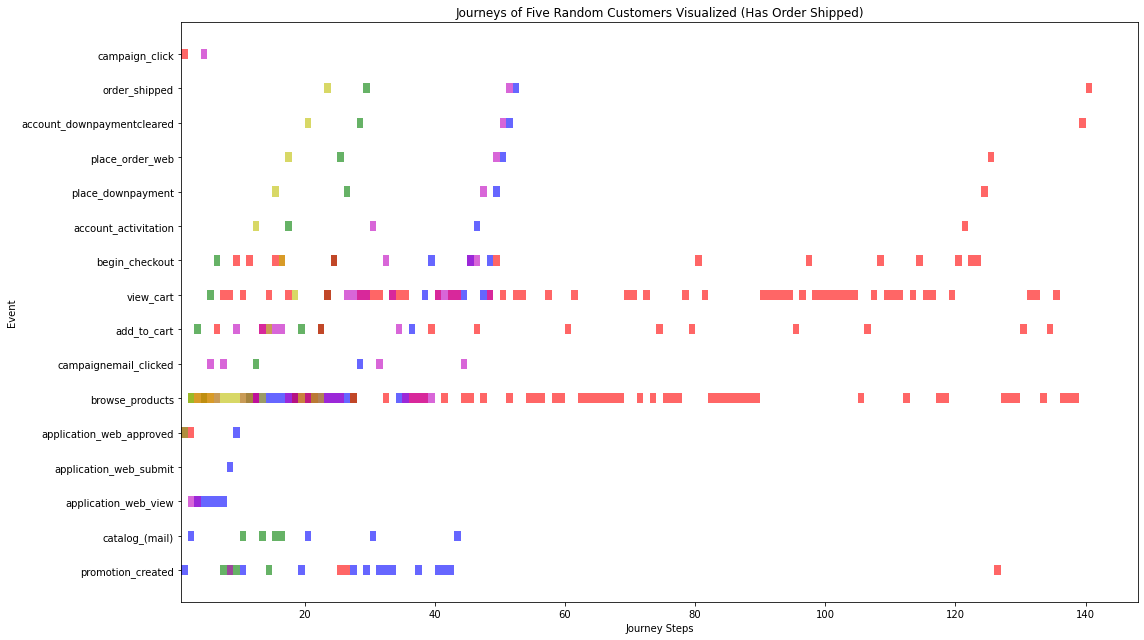

In [31]:
fig, ax = plt.subplots(figsize=(16, 9), tight_layout=True)
ax.barh(y="event_name", width=1, left="journey_steps_until_end", color = "color", height = 0.3, alpha = 0.6, data=test_df)
ax.set(xlabel="Journey Steps", ylabel="Event")
plt.title("Journeys of Five Random Customers Visualized (Has Order Shipped)")
# plt.savefig('yes_order.png')
plt.show()

In [32]:
test_df2 = nonorder_df.groupby(["account_id", "customer_id"])
a=np.arange(test_df2.ngroups)
np.random.shuffle(a)
test_df2 = nonorder_df[test_df2.ngroup().isin(a[:5])]
test_df2["account_id"].unique()

array([ 1349684429,  1633714259,  -626391530,  -878347095, -1992250888])

In [33]:
len(test_df2["account_id"].unique())

5

In [34]:
test_df2 = test_df2.reset_index(drop = True)
accounts = test_df2["account_id"].unique()
colors = ['b', 'g', 'r', 'm', 'y']
test_df2["color"] = np.nan
test_df2

,customer_id,account_id,stage,ed_id,event_name,event_timestamp,journey_steps_until_end,journey_id,color
0,1157772702,1349684429,Apply for Credit,19,application_web_view,2021-05-24 17:00:07,1,1.0,NaN
1,1157772702,1349684429,Apply for Credit,19,application_web_view,2021-05-25 02:02:24,2,1.0,NaN
2,1157772702,1349684429,Apply for Credit,19,application_web_view,2021-05-25 02:03:31,3,1.0,NaN
3,1157772702,1349684429,Apply for Credit,19,application_web_view,2021-05-25 02:03:32,4,1.0,NaN
4,1157772702,1349684429,Apply for Credit,19,application_web_view,2021-05-25 02:03:40,5,1.0,NaN
...,...,...,...,...,...,...,...,...,...
269,939011716,-626391530,NaN,1,promotion_created,2022-05-07 07:02:36.707,15,NaN,NaN
270,829674453,-878347095,Apply for Credit,12,application_web_approved,2023-05-11 15:47:01,1,1.0,NaN
271,829674453,-878347095,Discover,2,campaign_click,2023-05-11 21:47:01,2,1.0,NaN
272,332219473,-1992250888,Apply for Credit,15,application_phone_approved,2021-10-12 18:31:16,1,1.0,NaN


In [35]:
for i in range(len(test_df2)):
    if test_df2["account_id"][i] == accounts[0]:
        test_df2["color"][i] = colors[0]
    elif test_df2["account_id"][i] == accounts[1]:
        test_df2["color"][i] = colors[1]
    elif test_df2["account_id"][i] == accounts[2]:
        test_df2["color"][i] = colors[2]
    elif test_df2["account_id"][i] == accounts[3]:
        test_df2["color"][i] = colors[3]
    elif test_df2["account_id"][i] == accounts[4]:
        test_df2["color"][i] = colors[4]
    else: 
        np.nan

/var/folders/z4/1nckxbbs45q8z44xg1hvdp8c0000gn/T/ipykernel_1712/3393662695.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df2["color"][i] = colors[0]
/Users/joshuasusanto/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [36]:
test_df2.head()

,customer_id,account_id,stage,ed_id,event_name,event_timestamp,journey_steps_until_end,journey_id,color
0,1157772702,1349684429,Apply for Credit,19,application_web_view,2021-05-24 17:00:07,1,1.0,b
1,1157772702,1349684429,Apply for Credit,19,application_web_view,2021-05-25 02:02:24,2,1.0,b
2,1157772702,1349684429,Apply for Credit,19,application_web_view,2021-05-25 02:03:31,3,1.0,b
3,1157772702,1349684429,Apply for Credit,19,application_web_view,2021-05-25 02:03:32,4,1.0,b
4,1157772702,1349684429,Apply for Credit,19,application_web_view,2021-05-25 02:03:40,5,1.0,b


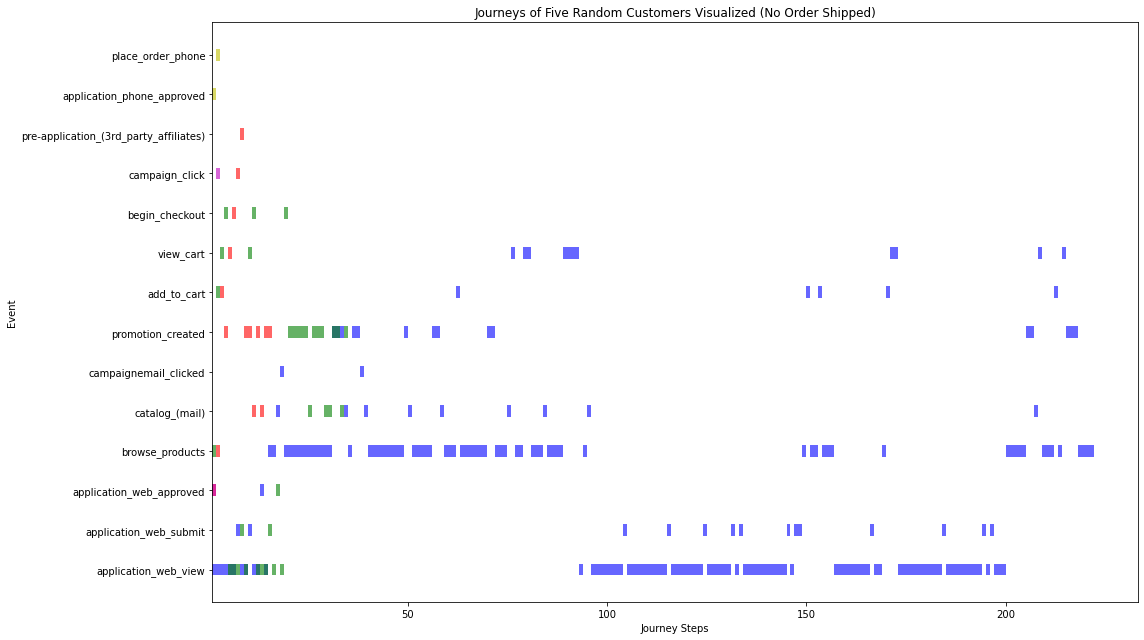

In [37]:
fig, ax = plt.subplots(figsize=(16, 9), tight_layout=True)
ax.barh(y="event_name", width=1, left="journey_steps_until_end", color = "color", height = 0.3, alpha = 0.6, data=test_df2)
ax.set(xlabel="Journey Steps", ylabel="Event")
plt.title("Journeys of Five Random Customers Visualized (No Order Shipped)")
# plt.savefig('no_order.png')
plt.show()

## Data Analysis and Modeling

In [3]:
# read frequency table and transformed data
freqs = pd.read_csv('freq_table.csv')
transformed_data = pd.read_csv('transformed_data.csv')

In [4]:
is_successful = np.zeros(len(transformed_data))
for i in range(len(transformed_data)):
    if transformed_data['journey_successful'][i] != 0:
        is_successful[i] = 1

In [5]:
freqs = freqs.iloc[:, 1:]

In [6]:
freqs.head()

,catalog_(email)_(experian),pre-application_(3rd_party_affiliates),browse_products,application_phone_pending,application_phone_declined,begin_checkout,campaignemail_clicked,application_web_view,place_order_web,application_web_submit,...,application_web_pending,site_registration,catalog_(mail),campaign_click,add_to_cart,promotion_created,account_downpaymentcleared,account_activitation,customer_requested_catalog_(digital),application_web_approved
0,0,0,0,0,0,0,0,3,0,1,...,0,0,0,1,0,0,0,0,0,1
1,0,0,66,0,0,0,0,5,0,1,...,0,0,0,1,2,5,0,0,0,1
2,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,0,0,11,0,1,...,0,0,0,0,0,4,0,0,0,1
4,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1


In [7]:
for i in range(28):
    print(Counter(freqs.iloc[:, i])[0]/1735766) # Percentage of 0s for each event

0.9996658535770374
0.9139100546963127
0.22326108473146725
0.999998271656433
0.9996785280965291
0.5125466220677211
0.7127976927765609
0.5165051049507825
0.8055567397909627
0.5839220263560871
0.9999550630672568
0.9682670359944832
0.9947199104026695
0.4306173758444399
0.8140423305906441
0.975522622288949
0.9776231358374343
0.8211158646960477
0.9999418124332428
0.9886926002698521
0.5753575078668438
0.412382775097565
0.42321199977416313
0.24646467323360408
0.8082126277389925
0.7600828683128947
0.9999988477709553
0.024780990064328948


In [8]:
# only keep relevant events as predictors
freqs = freqs[['browse_products', 
               'begin_checkout', 
               'campaignemail_clicked', 
               'application_web_view', 
               'application_web_submit', 
               'catalog_(mail)', 
               'campaign_click', 
               'add_to_cart', 
               'promotion_created']]

In [9]:
freqs.head()

,browse_products,begin_checkout,campaignemail_clicked,application_web_view,application_web_submit,catalog_(mail),campaign_click,add_to_cart,promotion_created
0,0,0,0,3,1,0,1,0,0
1,66,0,0,5,1,0,1,2,5
2,0,0,0,1,1,0,1,0,0
3,0,0,0,11,1,0,0,0,4
4,1,0,0,1,1,0,0,0,0


In [10]:
freqs_numpy = np.append(freqs.to_numpy(), is_successful.reshape(-1, 1), axis = 1)

### Logistic Regression

In [48]:
transformed_data.head()

,Unnamed: 0,customer_id,account_id,event_list,frequency_vector,recieved_promo,journey_successful
0,0,-784961211,1773350293,"['application_web_approved', 'application_web_...","[0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, ...",False,False
1,0,15849251,383997507,"['browse_products', 'browse_products', 'browse...","[0, 0, 66, 0, 0, 0, 0, 5, 0, 1, 0, 0, 0, 6, 0,...",True,False
2,0,155529381,1786111954,"['campaign_click', 'application_web_approved',...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",False,False
3,0,-1697747935,-1016455199,"['application_web_view', 'application_web_view...","[0, 0, 0, 0, 0, 0, 0, 11, 0, 1, 0, 0, 0, 0, 0,...",True,False
4,0,-986357645,1289564882,"['application_web_approved', 'browse_products'...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...",False,False


In [49]:
transformed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1735766 entries, 0 to 1735765
Data columns (total 7 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   Unnamed: 0          int64 
 1   customer_id         int64 
 2   account_id          int64 
 3   event_list          object
 4   frequency_vector    object
 5   recieved_promo      bool  
 6   journey_successful  bool  
dtypes: bool(2), int64(3), object(2)
memory usage: 69.5+ MB


In [5]:
# split 'frequency_vector' into a seperate columns
event_columns = transformed_data['frequency_vector'].str.split(',', expand = True)

# rename the new columns
event_columns.columns = [f"event_{i}" for i in range(1, event_columns.shape[1] + 1)]

# remove brackets from end columns
event_columns['event_1'] = event_columns['event_1'].str.replace('[', '')
event_columns['event_28'] = event_columns['event_28'].str.replace(']', '')

/var/folders/z4/1nckxbbs45q8z44xg1hvdp8c0000gn/T/ipykernel_2555/883051028.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  event_columns['event_1'] = event_columns['event_1'].str.replace('[', '')
/var/folders/z4/1nckxbbs45q8z44xg1hvdp8c0000gn/T/ipykernel_2555/883051028.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  event_columns['event_28'] = event_columns['event_28'].str.replace(']', '')


In [6]:
event_columns.head()

,event_1,event_2,event_3,event_4,event_5,event_6,event_7,event_8,event_9,event_10,...,event_19,event_20,event_21,event_22,event_23,event_24,event_25,event_26,event_27,event_28
0,0,0,0,0,0,0,0,3,0,1,...,0,0,0,1,0,0,0,0,0,1
1,0,0,66,0,0,0,0,5,0,1,...,0,0,0,1,2,5,0,0,0,1
2,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,0,0,11,0,1,...,0,0,0,0,0,4,0,0,0,1
4,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1


In [7]:
event_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1735766 entries, 0 to 1735765
Data columns (total 28 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   event_1   object
 1   event_2   object
 2   event_3   object
 3   event_4   object
 4   event_5   object
 5   event_6   object
 6   event_7   object
 7   event_8   object
 8   event_9   object
 9   event_10  object
 10  event_11  object
 11  event_12  object
 12  event_13  object
 13  event_14  object
 14  event_15  object
 15  event_16  object
 16  event_17  object
 17  event_18  object
 18  event_19  object
 19  event_20  object
 20  event_21  object
 21  event_22  object
 22  event_23  object
 23  event_24  object
 24  event_25  object
 25  event_26  object
 26  event_27  object
 27  event_28  object
dtypes: object(28)
memory usage: 370.8+ MB


In [9]:
event_columns = event_columns.apply(pd.to_numeric, errors = 'coerce')

In [14]:
event_columns.columns = event_order

In [15]:
event_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1735766 entries, 0 to 1735765
Data columns (total 28 columns):
 #   Column                                  Dtype
---  ------                                  -----
 0   catalog_(email)_(experian)              int64
 1   pre-application_(3rd_party_affiliates)  int64
 2   browse_products                         int64
 3   application_phone_pending               int64
 4   application_phone_declined              int64
 5   begin_checkout                          int64
 6   campaignemail_clicked                   int64
 7   application_web_view                    int64
 8   place_order_web                         int64
 9   application_web_submit                  int64
 10  fingerhut_university                    int64
 11  place_order_phone                       int64
 12  account_downpaymentreceived             int64
 13  view_cart                               int64
 14  order_shipped                           int64
 15  application_pho

In [16]:
# we included two methods to reach the same final dataframe as two of our members approached this problem differently!
event_columns.head()

,catalog_(email)_(experian),pre-application_(3rd_party_affiliates),browse_products,application_phone_pending,application_phone_declined,begin_checkout,campaignemail_clicked,application_web_view,place_order_web,application_web_submit,...,application_web_pending,site_registration,catalog_(mail),campaign_click,add_to_cart,promotion_created,account_downpaymentcleared,account_activitation,customer_requested_catalog_(digital),application_web_approved
0,0,0,0,0,0,0,0,3,0,1,...,0,0,0,1,0,0,0,0,0,1
1,0,0,66,0,0,0,0,5,0,1,...,0,0,0,1,2,5,0,0,0,1
2,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,0,0,11,0,1,...,0,0,0,0,0,4,0,0,0,1
4,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1


In [17]:
# split data into features (X) and target (Y)
X = event_columns[['browse_products', 'begin_checkout', 'campaignemail_clicked', 'application_web_view', 'application_web_submit', 'catalog_(mail)', 'campaign_click', 'add_to_cart', 'promotion_created']]
y = transformed_data['journey_successful']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 405)

# train a logistic regression model
start_time = datetime.now() # set start time
model = LogisticRegression(max_iter = 500)
model.fit(X_train, y_train)

# Predict on the test set
model_predictions = model.predict(X_test)
end_time = datetime.now() # set end time

# model diagnosis
conf_matrix = confusion_matrix(y_test, model_predictions)
accuracy = accuracy_score(y_test, model_predictions)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy}")

# computation time
print("Time Elapsed:", end_time - start_time)

Confusion Matrix:
[[343947   9261]
 [ 68654  12080]]
Accuracy: 0.8204483548492656
Time Elapsed: 0:00:07.758803


In [59]:
model.coef_

array([[ 0.01492959,  0.23384529,  0.05543219, -0.03464104,  0.0643752 ,
        -0.27999493, -0.08992376,  0.01856872, -0.18285904]])

### K-Nearest Neighbors

**Note:** This chunk also takes a very long time to run. Please refrain from doing so and refer to our written report for the accuracy and details of the model.

In [ ]:
# start time
start = datetime.now()

# initialize k
k_neighbors = 5

# Create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=k_neighbors)
knn_model.fit(X_train, y_train)

# Predictions and evaluation for KNN
knn_predictions = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)

# end time
end = datetime.now()

print("5-Nearest Neighbors:")
print(f"Accuracy: {knn_accuracy}")
print("Classification Report:")
print(classification_report(y_test, knn_predictions))
print("computation time:", end - start)

### Support Vector Machine

In [27]:
# initialize SVM Classifier
supportvm = SGDClassifier()

# fit classifier to data
supportvm.fit(X_train, y_train)

# use model to make predictions
svm_preds = supportvm.predict(X_test)

# diagnose accuracy
Counter(svm_preds == y_test)[True]/433942

0.8152955924985367

### Principal Component Analysis

In [18]:
# singular value decomposition
U,S,VT = np.linalg.svd(X, full_matrices=False)

In [19]:
# retaining the first two principal components 
X_PCA = X@VT[0:2,:].T
X_PCA.shape

(1735766, 2)

In [20]:
received_promo = transformed_data['recieved_promo']
success = transformed_data['journey_successful']

# concatenate 'X_PCA' and the binary columns 
X_full = pd.concat([X_PCA, received_promo, success], axis=1)

In [21]:
X_full.head()

,0,1,recieved_promo,journey_successful
0,-0.309631,-2.948307,False,False
1,-65.521900,3.071966,True,False
2,-0.122722,-1.133924,False,False
3,-1.466799,-11.398894,True,False
4,-1.084775,-0.951338,False,False


In [22]:
# define the range of numbers
low = 0  # lower bound (inclusive)
high = len(X_full)  # upper bound (exclusive)

# sample 100 random numbers between low and high
random_numbers = np.random.randint(low, high, size=100)

# print the sampled random numbers
print(random_numbers)

[  65405  796617 1038789  977782 1094060  352602  560200 1511933 1144190
 1236647 1519648  563298 1615194 1524021  529675  667063  464697 1143748
 1363974 1180401  779024  363805  343997  565342  282702  148166  368056
 1404226 1578243  772243  167033  387636 1334953 1680897  365651 1675657
  678435 1273498 1225239 1188260 1432960 1198667  742437 1519987 1208760
 1521031  801665   43939 1166543 1259994 1249314   44660 1080902  734558
 1329721  976882 1707289 1240098 1365347  734893 1248780  944289  445060
  800419  534276 1258421  425541  861549 1378680 1019211   17155 1377642
 1275834  578142 1098068   89984 1646327 1331326 1352722  551787  922301
 1389366  460329 1429816  825957  566490 1330341 1313107  871681 1350300
  881688 1034280  393006 1549271  437315   82103  613767 1676437  563419
 1537685]


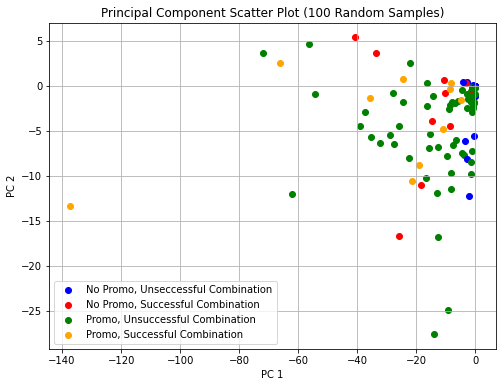

In [23]:
colors = {
    (False, False): 'blue',   # Binary column 1 is 0, Binary column 2 is 0
    (False, True): 'red',    # Binary column 1 is 0, Binary column 2 is 1
    (True, False): 'green',  # Binary column 1 is 1, Binary column 2 is 0
    (True, True): 'orange'  # Binary column 1 is 1, Binary column 2 is 1
}

# Create a scatter plot
plt.figure(figsize=(8, 6))
for i in random_numbers:
    plt.scatter(X_full[0][i], X_full[1][i], color = colors[(received_promo[i], success[i])])

# Add legend for colors
plt.scatter([], [], color='blue', label='No Promo, Unseccessful Combination')
plt.scatter([], [], color='red', label='No Promo, Successful Combination')
plt.scatter([], [], color='green', label='Promo, Unsuccessful Combination')
plt.scatter([], [], color='orange', label='Promo, Successful Combination')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Principal Component Scatter Plot (100 Random Samples)')
plt.legend()
plt.grid(True)
plt.show()

### KNN (With PCA)

In [24]:
X_PCA_train, X_PCA_test, y_PCA_train, y_PCA_test = train_test_split(X_PCA, y, test_size = 0.25, random_state = 405)

# start time
start = datetime.now()

# initialize k
k_neighbors = 50

# Create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=k_neighbors)
knn_model.fit(X_PCA_train, y_PCA_train)

# Predictions and evaluation for KNN
knn_predictions = knn_model.predict(X_PCA_test)
knn_accuracy = accuracy_score(y_PCA_test, knn_predictions)

# end time
end = datetime.now()

print("50-Nearest Neighbors:")
print(f"Accuracy: {knn_accuracy}")
print("Classification Report:")
print(classification_report(y_PCA_test, knn_predictions))
print("computation time:", end - start)

50-Nearest Neighbors:
Accuracy: 0.8322632978600827
Classification Report:
              precision    recall  f1-score   support

       False       0.85      0.97      0.90    353208
        True       0.63      0.24      0.35     80734

    accuracy                           0.83    433942
   macro avg       0.74      0.60      0.63    433942
weighted avg       0.81      0.83      0.80    433942

computation time: 0:01:13.706407


### K-means Clustering

In [25]:
k = 4  # desired number of clusters

# initialize KMeans 
kmeans = KMeans(n_clusters=k, random_state=0)

# fit the KMeans model 
kmeans.fit(X_PCA)

# cluster labels
cluster_labels = kmeans.labels_

pd.Series(cluster_labels).value_counts()

0    1406642
2     275940
1      48966
3       4218
dtype: int64

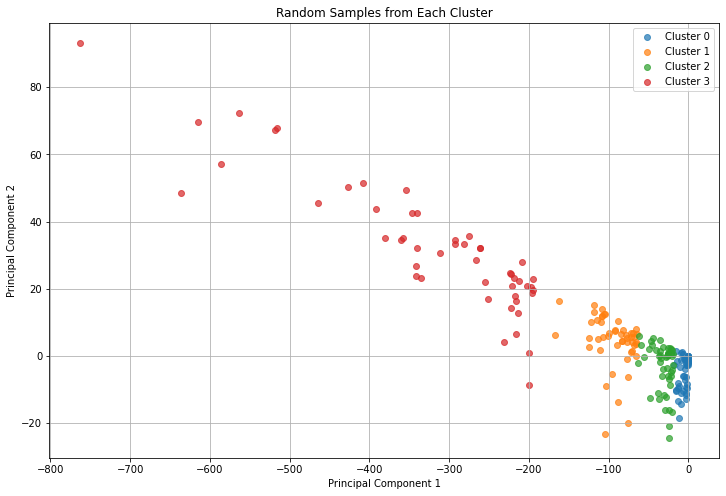

In [37]:
# plotting our clusters

n = 50 # how many of each cluster we want to sample

# initialize figure
plt.figure(figsize=(12, 8))

indices = []

# iterate over each cluster
for cluster in range(k):
    # select indices of data points belonging to the i-th cluster
    cluster_indices = np.where(cluster_labels == cluster)[0]
    
    # randomly sample n points from this cluster
    random_samples_indices = np.random.choice(cluster_indices, n, replace=False)
    indices.extend(list(random_samples_indices))
    
    
    # plot the random samples from the current cluster
    plt.scatter(X_PCA[0][random_samples_indices], X_PCA[1][random_samples_indices], label=f'Cluster {cluster}', alpha=0.7)

# labels and legend
plt.title('Random Samples from Each Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 864x576 with 0 Axes>

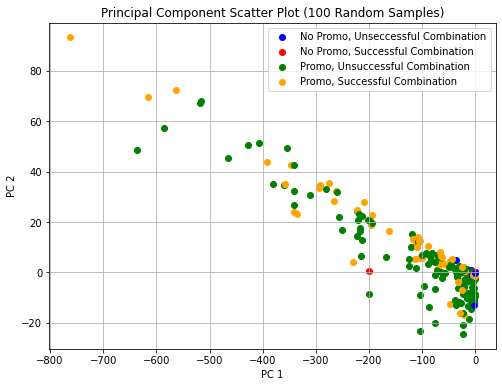

In [39]:
plt.figure(figsize=(12, 8))

plt.figure(figsize=(8, 6))
for i in indices:
    plt.scatter(X_full[0][i], X_full[1][i], color = colors[(received_promo[i], success[i])])

plt.scatter([], [], color='blue', label='No Promo, Unseccessful Combination')
plt.scatter([], [], color='red', label='No Promo, Successful Combination')
plt.scatter([], [], color='green', label='Promo, Unsuccessful Combination')
plt.scatter([], [], color='orange', label='Promo, Successful Combination')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Principal Component Scatter Plot (Clustered Points)')
plt.legend()
plt.grid(True)
plt.show()